# Spam Detection with Neural Networks

A common use for binary classification is sorting spam e-mails from legitimate e-mails. It's not difficult to build a neural network that classifies text. Let's use Keras to build a binary classifier for e-mails, train it with a collection of e-mails labeled with 0s (for not spam) and 1s (for spam), and then run a few e-mails through it to see how well it performs.

## Load and prepare the data

The first step is to load the dataset and prepare it for use in deep learning. We'll use Keras's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class to vectorize the text in the training e-mails. We won't bother to remove stop words because doing so has little to no effect on the outcome.

In [1]:
import pandas as pd
 
df = pd.read_csv('Data/ham-spam.csv')
df = df.sample(frac=1, random_state=0)
df.head()

,IsSpam,Text
993,1,utf date course utf diminish weight our table...
859,1,utf any drugs eur utf for dose have you ever ...
298,0,expert finderhttps expertfinder enron com
553,1,and courtiers ministerssubsegment founded res...
672,1,for our clients fargo dear customer have updat...


Remove duplicate rows from the dataset and check for balance.

In [2]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499         expert finderhttps expertfinder enron com     1
1        500    500   utf date course utf diminish weight our table...    1

Extract text from the "Text" column and labels from the "IsSpam" column. Then tokenize the text and create padded sequences from it.

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
x = df['Text']
y = df['IsSpam']

max_words = 10000 # Limit the vocabulary to the 10,000 most common words
max_length = 500
 
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
x = pad_sequences(sequences, maxlen=max_length)

## Train a neural network to identify spam

Create a neural network containing an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer for converting sequences into arrays of word vectors and a [`Dense`](https://keras.io/api/layers/core_layers/dense/) layer for classifying arrays of word vectors.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
 
model = Sequential() 
model.add(Embedding(max_words, 32, input_length=max_length)) 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 16000)             0         
                                                                 
 dense (Dense)               (None, 128)               2048128   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,368,257
Trainable params: 2,368,257
Non-trainable params: 0
_________________________________________________________________


Train the network.

In [5]:
hist = model.fit(x, y, validation_split=0.2, epochs=5, batch_size=20)

Epoch 1/5
40/40 [==============================] - 3s 50ms/step - loss: 0.6387 - accuracy: 0.6308 - val_loss: 0.5589 - val_accuracy: 0.7100
Epoch 2/5
40/40 [==============================] - 2s 44ms/step - loss: 0.3128 - accuracy: 0.9011 - val_loss: 0.2004 - val_accuracy: 0.9350
Epoch 3/5
40/40 [==============================] - 2s 45ms/step - loss: 0.0632 - accuracy: 0.9837 - val_loss: 0.1314 - val_accuracy: 0.9600
Epoch 4/5
40/40 [==============================] - 2s 45ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.1116 - val_accuracy: 0.9700
Epoch 5/5
40/40 [==============================] - 2s 40ms/step - loss: 0.0112 - accuracy: 0.9987 - val_loss: 0.1136 - val_accuracy: 0.9700


Chart the training and validation accuracy for each epoch.

[]

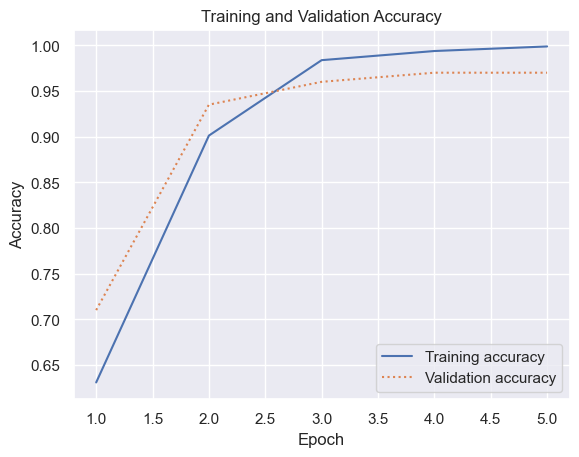

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Use the model to classify e-mails

Now let's see how the model classifies some sample e-mails. We'll start with a message that is not spam. The model's `predict` method predicts the probability that the input belongs to the positive class (spam).

In [7]:
text = 'Can you attend a code review on Tuesday? ' \
       'Need to make sure the logic is rock solid.'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 [==============================] - 0s 113ms/step


0.49056807

Now test the model with a spam message.

In [8]:
text = 'Why pay more for expensive meds when ' \
       'you can order them online and save $$$?'

sequence = tokenizer.texts_to_sequences([text])
padded_sequence = pad_sequences(sequence, maxlen=max_length)
model.predict(padded_sequence)[0][0]

1/1 [==============================] - 0s 32ms/step


0.9905545

What did the network predict for the first e-mail? What about the second? Do you agree with the predictions? Remember that a number close to 0.0 indicates that the e-mail is not spam, while a number close to 1.0 indicates that it is.

Вместо того чтобы запускать Tokenizer и pad_sequences вручную, можно предварить эмбеддинговый слой слоем TextVectorization.

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.layers import TextVectorization, InputLayer
import tensorflow as tf
model = Sequential()
model.add(InputLayer(input_shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_words, output_sequence_length=max_length))
model.add(Embedding(max_words, 32, input_length=max_length))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 500, 32)           320000    
                                                                 
 flatten_2 (Flatten)         (None, 16000)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2048128   
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,368,257
Trainable params: 2,368,257
Non-trainable params: 0
____________________________________________

Обратите внимание, что входной слой теперь явно определен, и он настроен на прием строковых данных. Кроме того, перед обучением модели слой TextVectorization необходимо подогнать под входные данные путем вызова оператора adapt:

In [ ]:
model.layers[0].adapt(x)

In [ ]:
text = 'Why pay more for expensive meds when ' \
'you can order them online and save $$$?'
model.predict([text])[0][0]

TextVectorization не удаляет стоп-слова, поэтому, если необходимо удалить их, можно проделать это отдельно или использовать параметр standardtze слоя TextVectorization для определения функции обратного вызова, которая сделает это за вас.